In [2]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Auxiliary Functions

In [3]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [4]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [5]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [6]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

In [7]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [8]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [9]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [10]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [11]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [12]:
def get_corresponding_df(df, group_name):
    if group_name == "Female_ADHD":
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif group_name == "Female_noADHD":
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif group_name == "ADHD":
        topic_df = df[df["group"].isin(["Male_ADHD", "Female_ADHD"])]
        print("ADHD")
    elif group_name == "noADHD":
        topic_df = df[df["group"].isin(["Male_noADHD", "Female_noADHD"])]
        print("noADHD")
    return topic_df

# Preload

In [13]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

In [14]:
def preliminary_steps(group_name, folder):
    print(f"Running preliminary steps for group: {group_name}, folder: {folder}")
    df_group = get_corresponding_df(topic_df, group_name)
    path = f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/{folder}/"
    output_folder = f"../../outputs/bertopic_tuning/{group_name}/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [15]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    
    # Generate and save hierarchical topics (this usually works fine)
    try:
        print("🔄 Generating hierarchical topics...")
        hierarchical_topics = topic_model.hierarchical_topics(texts)
        print("✅ Hierarchical topics generated successfully")
        
        # Visualize hierarchy (this also usually works)
        try:
            print("🔄 Creating hierarchy visualization...")
            fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
            save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Hierarchy visualization saved")
        except Exception as e:
            print(f"⚠️  Warning: Could not create hierarchy visualization: {e}")
            
    except Exception as e:
        print(f"⚠️  Warning: Could not generate hierarchical topics: {e}")
    
    # Get and save topic info (this always works)
    try:
        topic_info = topic_model.get_topic_info()
        topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)
        
        num_unique_topics = topic_info['Topic'].nunique()
        num_real_topics = len(topic_info[topic_info['Topic'] != -1])  # Exclude outlier topic
        
        print(f"📊 Number of unique topics: {num_unique_topics}")
        print(f"📊 Number of real topics (excluding outliers): {num_real_topics}")
        
        # Save topic summary
        with open(f"{output_folder}/topic_summary.txt", "w") as f:
            f.write(f"Total unique topics: {num_unique_topics}\n")
            f.write(f"Real topics (excluding outliers): {num_real_topics}\n")
            f.write(f"Total documents: {len(texts)}\n")
            f.write(f"Documents per topic (avg): {len(texts) / max(num_real_topics, 1):.2f}\n")
            
    except Exception as e:
        print(f"❌ Error getting topic info: {e}")
        return topic_model
    
    # Try to create topic visualization with enhanced error handling
    if num_real_topics <= 3:
        print("⚠️  Cannot create topic visualization: Need at least 3 real topics")
        print("💡 This model has too few distinct topics for meaningful visualization")
        
        # Save a note about why visualization was skipped
        with open(f"{output_folder}/visualization_notes.txt", "w") as f:
            f.write(f"Topic visualization skipped: Only {num_real_topics} real topics found\n")
            f.write("Minimum 2 topics required for UMAP dimensionality reduction\n")
            
    elif num_real_topics <= 4:
        print("⚠️  Very few topics detected. Attempting visualization with fallback options...")
        
        # Try with different UMAP parameters for small datasets
        try:
            print("🔄 Attempting topic visualization with adjusted parameters...")
            
            # Create a custom UMAP with parameters suitable for small datasets
            from umap import UMAP
            
            # Override the model's UMAP temporarily with safer parameters
            original_umap = topic_model.umap_model
            
            # Use parameters that work better with few topics
            safe_umap = UMAP(
                n_neighbors=min(2, num_real_topics),  # Very small n_neighbors
                n_components=2,
                metric="cosine",
                random_state=42,
                min_dist=0.1,
                spread=1.0
            )
            
            topic_model.umap_model = safe_umap
            
            # Try the visualization
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created with adjusted parameters")
            
            # Restore original UMAP
            topic_model.umap_model = original_umap
            
        except (TypeError, ValueError) as e:
            if "k >= N" in str(e) or "zero-size array" in str(e):
                print("⚠️  UMAP spectral initialization failed due to insufficient data")
                print("💡 This is expected with very few topics - the model is still valid")
                
                # Save detailed error info
                with open(f"{output_folder}/visualization_error.txt", "w") as f:
                    f.write(f"Visualization failed due to insufficient topic diversity\n")
                    f.write(f"Error: {str(e)}\n")
                    f.write(f"Real topics: {num_real_topics}\n")
                    f.write(f"This is a known limitation when fewer than 5-6 topics exist\n")
                    
            else:
                print(f"❌ Unexpected error in topic visualization: {e}")
                
        except Exception as e:
            print(f"❌ Other error in topic visualization: {e}")
            
    else:
        # Normal case: enough topics for standard visualization
        try:
            print("🔄 Creating standard topic visualization...")
            fig_topics = topic_model.visualize_topics(custom_labels=True)
            save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Topic visualization created successfully")
        except Exception as e:
            print(f"❌ Error in standard topic visualization: {e}")
    
    return topic_model

In [17]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [18]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    
    # Check topic distribution before attempting datamap
    topic_info = topic_model.get_topic_info()
    real_topics = topic_info[topic_info['Topic'] != -1]
    print(f"Number of real topics (excluding outliers): {len(real_topics)}")
    
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)

    # Check if we have enough valid topics for datamap visualization
    if len(real_topics) < 2:
        print(f"⚠️  Skipping document datamap: Only {len(real_topics)} real topics found (minimum 2 required)")
        with open(f"{output_folder}/datamap_skipped.txt", "w") as f:
            f.write(f"Document datamap skipped: Only {len(real_topics)} real topics found\n")
            f.write("Minimum 2 real topics required for meaningful datamap visualization\n")
    else:
        try:
            print("🔄 Creating document datamap...")
            embeddings = np.vstack(df_group["response_embedding"])
            fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
            save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
            print("✅ Document datamap created successfully")
        except ValueError as e:
            if "array of sample points is empty" in str(e):
                print("⚠️  Skipping document datamap: Insufficient valid data points for visualization")
                print("💡 This typically happens when most documents are classified as outliers")
                with open(f"{output_folder}/datamap_error.txt", "w") as f:
                    f.write(f"Document datamap failed: {str(e)}\n")
                    f.write("This typically indicates insufficient topic diversity or too many outliers\n")
            else:
                print(f"❌ Unexpected error in document datamap: {e}")
                raise e
        except Exception as e:
            print(f"❌ Error creating document datamap: {e}")

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Save translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    else:
        print("No valid topics to display")

# Female ADHD

In [ ]:
group_name = "Female_ADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folder = [name for name in folders if name.startswith("2_")][0]
folder

'2_reduced_9_20250825_010652'

Running preliminary steps for group: Female_ADHD, folder: 2_20250824_194550
Female_ADHD


2025-08-25 00:48:46,165 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:48:46,170 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:48:46,182 - BERTopic - Representation - Completed ✓
2025-08-25 00:48:46,184 - BERTopic - Topic reduction - Reduced number of topics from 10 to 9


🔄 Generating hierarchical topics...


100%|██████████| 7/7 [00:00<00:00, 588.36it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250825_004846_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250825_004846_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550_reduced_9
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 9
📊 Number of real topics (excluding outliers): 8
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250825_004847_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250825_004847_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s)

Document  Topic  \
0   Pedras, necrópoles, minerais, música, cinema, ...      5   
1   Um dos meus interesses especiais é skincare co...     -1   
2   Pergunta difícil porque tenho vários e eles vã...      5   
3   Animais, sempre amei animais e é a minha maior...      6   
4   Adoro ler, embora agora esteja sem muita vonta...      0   
..                                                ...    ...   
60  A PHDA influencia tudo na minha vida. Mas prin...      2   
61  "O serial killer e o bode espiatorio". O pânic...      2   
62  O ponto em que sociedade se está a tornar,: eg...      2   
63  Gostava que não dissessem : toda a gente tem p...      2   
64  Não sei explicar o que se anda a passar comigo...     -1   

                          Name                         CustomName  \
0   5_há_harry_incrível_potter         Mental and Physical Health   
1             -1_que_de_me_não                      Outlier Topic   
2   5_há_harry_incrível_potter         Mental and Physical Health   
3      6_animais_são_nós_gatos    Fascination with Magical Worlds   
4          0_de_que_não_sailor    Personal Daily Life Reflections   
..                         ...                                ...   
60      2_entristece_que_me_as  Academic Overwhelm and Self-Doubt   
61      2_entristece_que_me_as  Academic Overwhelm and Self-Doubt   
62      2_entristece_que_me_as  Academic Overwhelm and Self-Doubt   
63      2_entristece_que_me_as  Academic Overwhelm and Self-Doubt   
64            -1_que_de_me_não                      Outlier Topic   

                                       Representation  \
0   [há, harry, incrível, potter, um, mundo, como,...   
1   [que, de, me, não, ser, eu, minha, mas, meus, ...   
2   [há, harry, incrível, potter, um, mundo, como,...   
3   [animais, são, nós, gatos, os, como, que, de, ...   
4   [de, que, não, sailor, consigo, fazer, mas, le...   
..                                                ...   
60  [entristece, que, me, as, com, pessoas, phda, ...   
61  [entristece, que, me, as, com, pessoas, phda, ...   
62  [entristece, que, me, as, com, pessoas, phda, ...   
63  [entristece, que, me, as, com, pessoas, phda, ...   
64  [que, de, me, não, ser, eu, minha, mas, meus, ...   

                                              KeyBERT  \
0   [sentimentos, pensamentos, saúde, comportament...   
1   [tornei, comigo mesma, mim, comigo, passei, cé...   
2   [sentimentos, pensamentos, saúde, comportament...   
3   [especial, interesse especial, criar, vários, ...   
4   [ansiedade, dor, tirar, fiz, memória, apeteceu...   
..                                                ...   
60  [sinto, faço, comigo própria, mim, quero dormi...   
61  [sinto, faço, comigo própria, mim, quero dormi...   
62  [sinto, faço, comigo própria, mim, quero dormi...   
63  [sinto, faço, comigo própria, mim, quero dormi...   
64  [tornei, comigo mesma, mim, comigo, passei, cé...   

                                  OpenAI  \
0           [Mental and Physical Health]   
1   [Self-Discovery and Social Identity]   
2           [Mental and Physical Health]   
3      [Fascination with Magical Worlds]   
4      [Personal Daily Life Reflections]   
..                                   ...   
60   [Academic Overwhelm and Self-Doubt]   
61   [Academic Overwhelm and Self-Doubt]   
62   [Academic Overwhelm and Self-Doubt]   
63   [Academic Overwhelm and Self-Doubt]   
64  [Self-Discovery and Social Identity]   

                                                  MMR  \
0   [saúde, interesse, comida, pergunta difícil, j...   
1   [amigos, sempre, nunca, vida, mim, ano, social...   
2   [saúde, interesse, comida, pergunta difícil, j...   
3   [sei explicar, explicar, mundo acho, vários, p...   
4   [hoje, melhor, tirar, voltei, horas, gostava, ...   
..                                                ...   
60  [coisas, sinto, escrever, trabalhar ainda, que...   
61  [coisas, sinto, escrever, trabalhar ainda, que...   
62  [coisas, sinto, escrever, traba

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250825_004849_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250825_004849_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550_reduced_9
------------------------------------------------------------


4it [00:00, 170.94it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250825_004851_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250825_004851_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550_reduced_9
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250825_004854_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250825_004854_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_ADHD/2_20250824_194550_reduced_9
------------------------------------

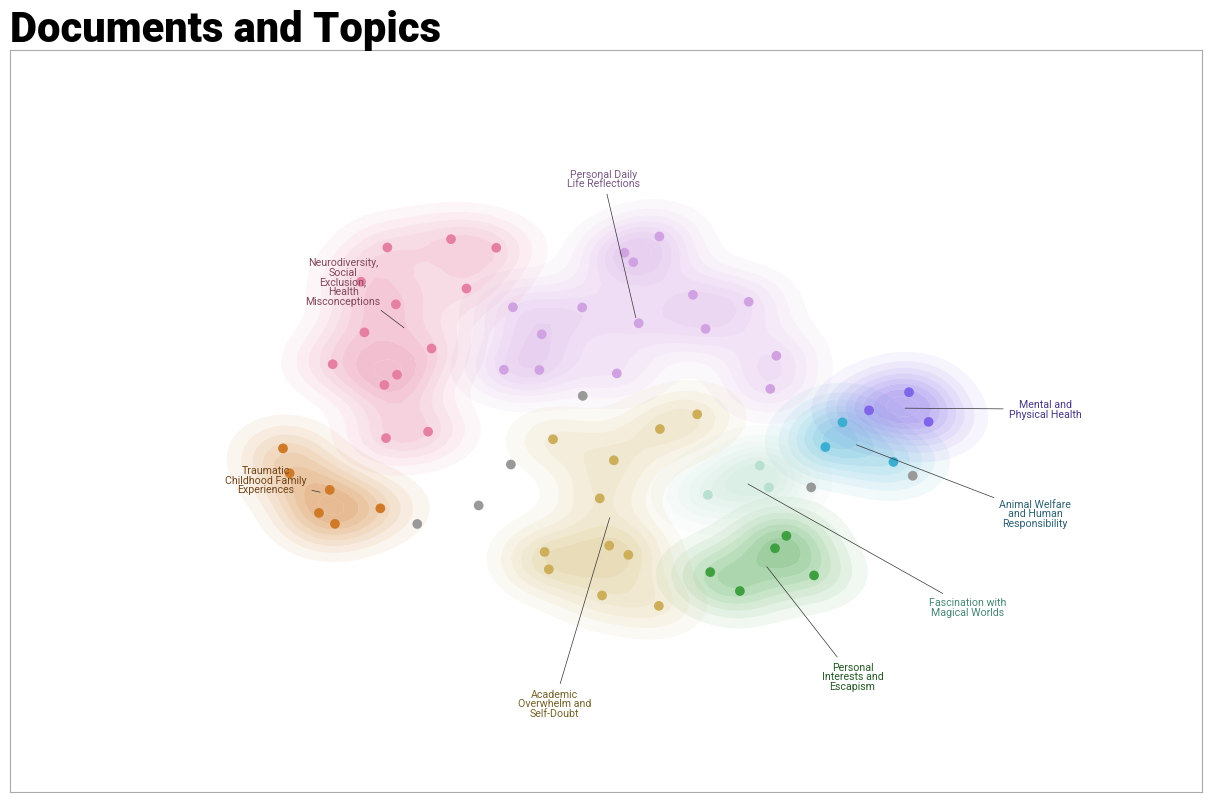

: 

In [ ]:
num_topics = [9, 8, 7, 6, 5]
for num in num_topics:
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    output_folder = f"../../outputs/bertopic_tuning/reduced_{group_name}/{folder}_reduced_{num}/"
    os.makedirs(output_folder, exist_ok=True)
    texts = df_group["response"].tolist()
    topic_model.reduce_topics(texts, nr_topics=num)
    chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
    chatgpt_topic_labels[-1] = "Outlier Topic"
    topic_model.set_topic_labels(chatgpt_topic_labels)

    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# Female noADHD

In [19]:
group_name = "Female_noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folder = [name for name in folders if name.startswith("3_")][0]
folder

'3_20250824_203413'

Running preliminary steps for group: Female_noADHD, folder: 3_20250824_203413
Female_noADHD


2025-08-25 00:17:58,077 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:17:58,082 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:17:58,105 - BERTopic - Representation - Completed ✓
2025-08-25 00:17:58,106 - BERTopic - Topic reduction - Reduced number of topics from 24 to 11


🔄 Generating hierarchical topics...


100%|██████████| 9/9 [00:00<00:00, 524.70it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_001758_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_001758_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_11
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 11
📊 Number of real topics (excluding outliers): 10
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_001806_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_001806_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      2   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      2   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      0   
216                                                  —      5   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      0   
219  Alguém me mande um milagre, I am going crazy, ...      1   

                              Name                              CustomName  \
0         2_gosto_ler_porque_forma       Passion for Reading and Mythology   
1         2_gosto_ler_porque_forma       Passion for Reading and Mythology   
2          -1_dia_gosto_dias_todos                           Outlier Topic   
3         2_gosto_ler_porque_forma       Passion for Reading and Mythology   
4          -1_dia_gosto_dias_todos                           Outlier Topic   
..                             ...                                     ...   
215    0_memória_sempre_lembro_mim              Daily Stress and Overwhelm   
216  5_biblioteca_escrita_pessoas_  Challenges in Recalling Daily Memories   
217        -1_dia_gosto_dias_todos                           Outlier Topic   
218    0_memória_sempre_lembro_mim              Daily Stress and Overwhelm   
219        1_dia_hoje_fazer_porque            Gender, Activism, AI Anxiety   

                                        Representation  \
0    [gosto, ler, porque, forma, interesse, adoro, ...   
1    [gosto, ler, porque, forma, interesse, adoro, ...   
2    [dia, gosto, dias, todos, bem, hoje, animais, ...   
3    [gosto, ler, porque, forma, interesse, adoro, ...   
4    [dia, gosto, dias, todos, bem, hoje, animais, ...   
..                                                 ...   
215  [memória, sempre, lembro, mim, pessoas, tudo, ...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, todos, bem, hoje, animais, ...   
218  [memória, sempre, lembro, mim, pessoas, tudo, ...   
219  [dia, hoje, fazer, porque, trabalho, pai, ir, ...   

                                               KeyBERT  \
0    [livros, ler, the, lido, histórias, escrita, r...   
1    [livros, ler, the, lido, histórias, escrita, r...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [livros, ler, the, lido, histórias, escrita, r...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [stress, stressada, acordei, ansiosa, fiquei, ...   
216  [memórias, esqueço, emoções, senti, sinto, mom...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [stress, stressada, acordei, ansiosa, fiquei, ...   
219  [mexer, mim sinto, dificuldades, políticas, cr...   

                                       OpenAI  \
0         [Passion for Reading and Mythology]   
1         [Passion for Reading and Mythology]   
2           [Personal Daily Life Experiences]   
3         [Passion for Reading and Mythology]   
4           [Personal Daily Life Experiences]   
..                                        ...   
215              [Daily Stress and Overwhelm]   
216  [Challenges in Recalling Daily Memories]   
217         [Personal Daily Life Experiences]   
218              [Daily Stress and Overwhelm]   
219            [Gender, Activism, AI Anxiety]   

                                                   MMR  \
0    [história, músicas, livros, gosto, amor, volta...   
1    [história, músicas, livros, gosto, amor, volta...   
2    [animais, dias, ainda, jogos, diferentes, anos...   
3    [história, músicas, livros, gosto, amor, volta...   
4    [animais, dias, ainda, jogos, diferentes, anos... 

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_001808_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_001808_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_11
------------------------------------------------------------


4it [00:00, 139.46it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_001809_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_001809_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_11
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_001814_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_001814_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_11
----------

2025-08-25 00:18:33,456 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:18:33,460 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:18:33,481 - BERTopic - Representation - Completed ✓
2025-08-25 00:18:33,482 - BERTopic - Topic reduction - Reduced number of topics from 24 to 14


🔄 Generating hierarchical topics...


100%|██████████| 12/12 [00:00<00:00, 562.10it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_001833_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_001833_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_14
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 14
📊 Number of real topics (excluding outliers): 13
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_001835_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_001835_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      2   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      1   
216                                                  —      8   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                               Name                               CustomName  \
0        4_gosto_adoro_cozinhar_bem    Grandparents, Memory, Loss, Childhood   
1    2_ler_gosto_interesse_história        Passion for Reading and Mythology   
2           -1_dia_gosto_dias_todos                            Outlier Topic   
3    2_ler_gosto_interesse_história        Passion for Reading and Mythology   
4           -1_dia_gosto_dias_todos                            Outlier Topic   
..                              ...                                      ...   
215     1_pessoas_sempre_vezes_algo             Gender, Activism, AI Anxiety   
216   8_biblioteca_escrita_pessoas_  Traveling and Experiencing New Cultures   
217         -1_dia_gosto_dias_todos                            Outlier Topic   
218     1_pessoas_sempre_vezes_algo             Gender, Activism, AI Anxiety   
219         0_dia_hoje_fazer_porque               Daily Stress and Overwhelm   

                                        Representation  \
0    [gosto, adoro, cozinhar, bem, acalma, porque, ...   
1    [ler, gosto, interesse, história, músicas, liv...   
2    [dia, gosto, dias, todos, animais, bem, conseg...   
3    [ler, gosto, interesse, história, músicas, liv...   
4    [dia, gosto, dias, todos, animais, bem, conseg...   
..                                                 ...   
215  [pessoas, sempre, vezes, algo, sinto, perceber...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, todos, animais, bem, conseg...   
218  [pessoas, sempre, vezes, algo, sinto, perceber...   
219  [dia, hoje, fazer, porque, trabalho, pai, ir, ...   

                                               KeyBERT  \
0    [memória vem, cresci, memória, conheci, durant...   
1    [livros, ler, the, lido, histórias, escrita, r...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [livros, ler, the, lido, histórias, escrita, r...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [mexer, mim sinto, dificuldades, políticas, cr...   
216  [viajar, viver, sentir, mim sinto, viagem, ir ...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                        OpenAI  \
0      [Grandparents, Memory, Loss, Childhood]   
1          [Passion for Reading and Mythology]   
2            [Personal Daily Life Experiences]   
3          [Passion for Reading and Mythology]   
4            [Personal Daily Life Experiences]   
..                                         ...   
215             [Gender, Activism, AI Anxiety]   
216  [Traveling and Experiencing New Cultures]   
217          [Personal Daily Life Experiences]   
218             [Gender, Activism, AI Anxiety]   
219               [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [memória, amor, nunca, ovo, acontecimento, vár...   
1    [história, músicas, livros, gosto, amor, volta...   
2    [animais, dias, ainda, jogos, diferentes, anos...   
3    [história, músicas, livros, gosto, amor, volta...   
4    [animais, dias

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_001836_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_001836_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_14
------------------------------------------------------------


4it [00:00, 130.52it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_001838_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_001838_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_14
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_001841_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_001841_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_14
----------

2025-08-25 00:19:06,973 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:19:06,976 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:19:06,997 - BERTopic - Representation - Completed ✓
2025-08-25 00:19:06,998 - BERTopic - Topic reduction - Reduced number of topics from 24 to 15


🔄 Generating hierarchical topics...


100%|██████████| 13/13 [00:00<00:00, 612.80it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_001907_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_001907_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_15
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 15
📊 Number of real topics (excluding outliers): 14
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_001908_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_001908_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      2   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      2   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      1   
216                                                  —     10   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                               Name                             CustomName  \
0     4_cozinhar_gosto_adoro_acalma  Grandparents, Memory, Loss, Childhood   
1    2_ler_gosto_interesse_história      Passion for Reading and Mythology   
2           -1_dia_gosto_dias_todos                          Outlier Topic   
3    2_ler_gosto_interesse_história      Passion for Reading and Mythology   
4           -1_dia_gosto_dias_todos                          Outlier Topic   
..                              ...                                    ...   
215     1_pessoas_sempre_vezes_algo           Gender, Activism, AI Anxiety   
216  10_biblioteca_escrita_pessoas_          Mental Health Self-Reflection   
217         -1_dia_gosto_dias_todos                          Outlier Topic   
218     1_pessoas_sempre_vezes_algo           Gender, Activism, AI Anxiety   
219         0_dia_hoje_fazer_porque             Daily Stress and Overwhelm   

                                        Representation  \
0    [cozinhar, gosto, adoro, acalma, porque, cor, ...   
1    [ler, gosto, interesse, história, músicas, liv...   
2    [dia, gosto, dias, todos, animais, consegui, h...   
3    [ler, gosto, interesse, história, músicas, liv...   
4    [dia, gosto, dias, todos, animais, consegui, h...   
..                                                 ...   
215  [pessoas, sempre, vezes, algo, sinto, perceber...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, todos, animais, consegui, h...   
218  [pessoas, sempre, vezes, algo, sinto, perceber...   
219  [dia, hoje, fazer, porque, trabalho, pai, ir, ...   

                                               KeyBERT  \
0    [memória vem, cresci, memória, conheci, durant...   
1    [livros, ler, the, lido, histórias, escrita, r...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [livros, ler, the, lido, histórias, escrita, r...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [mexer, mim sinto, dificuldades, políticas, cr...   
216  [mental, conseguir, cansativo, muitas vezes, s...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                      OpenAI  \
0    [Grandparents, Memory, Loss, Childhood]   
1        [Passion for Reading and Mythology]   
2          [Personal Daily Life Experiences]   
3        [Passion for Reading and Mythology]   
4          [Personal Daily Life Experiences]   
..                                       ...   
215           [Gender, Activism, AI Anxiety]   
216          [Mental Health Self-Reflection]   
217        [Personal Daily Life Experiences]   
218           [Gender, Activism, AI Anxiety]   
219             [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [memória, amor, nunca, ovo, acontecimento, vár...   
1    [história, músicas, livros, gosto, amor, volta...   
2    [animais, dias, ainda, jogos, diferentes, anos...   
3    [história, músicas, livros, gosto, amor, volta...   
4    [animais, dias, ainda, jogos, diferentes, anos...   
..       

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_001910_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_001910_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_15
------------------------------------------------------------


4it [00:00, 135.22it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_001911_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_001911_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_15
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_001915_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_001915_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_15
----------

2025-08-25 00:19:41,861 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:19:41,865 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:19:41,888 - BERTopic - Representation - Completed ✓
2025-08-25 00:19:41,889 - BERTopic - Topic reduction - Reduced number of topics from 24 to 16


🔄 Generating hierarchical topics...


100%|██████████| 14/14 [00:00<00:00, 608.44it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_001941_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_001941_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_16
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 16
📊 Number of real topics (excluding outliers): 15
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_001943_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_001943_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      3   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      3   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      1   
216                                                  —     10   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                               Name                              CustomName  \
0     4_cozinhar_gosto_adoro_acalma   Grandparents, Memory, Loss, Childhood   
1     3_ler_história_músicas_livros  Personal Struggles and Family Dynamics   
2           -1_dia_gosto_dias_todos                           Outlier Topic   
3     3_ler_história_músicas_livros  Personal Struggles and Family Dynamics   
4           -1_dia_gosto_dias_todos                           Outlier Topic   
..                              ...                                     ...   
215     1_pessoas_sempre_vezes_algo            Gender, Activism, AI Anxiety   
216  10_biblioteca_escrita_pessoas_           Mental Health Self-Reflection   
217         -1_dia_gosto_dias_todos                           Outlier Topic   
218     1_pessoas_sempre_vezes_algo            Gender, Activism, AI Anxiety   
219         0_dia_hoje_fazer_porque              Daily Stress and Overwhelm   

                                        Representation  \
0    [cozinhar, gosto, adoro, acalma, porque, cor, ...   
1    [ler, história, músicas, livros, forma, intere...   
2    [dia, gosto, dias, todos, animais, consegui, h...   
3    [ler, história, músicas, livros, forma, intere...   
4    [dia, gosto, dias, todos, animais, consegui, h...   
..                                                 ...   
215  [pessoas, sempre, vezes, algo, sinto, perceber...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, todos, animais, consegui, h...   
218  [pessoas, sempre, vezes, algo, sinto, perceber...   
219  [dia, hoje, fazer, porque, trabalho, pai, ir, ...   

                                               KeyBERT  \
0    [memória vem, cresci, memória, conheci, durant...   
1    [acordei tarde, comecei dia, comecei trabalhar...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [acordei tarde, comecei dia, comecei trabalhar...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [mexer, mim sinto, dificuldades, políticas, cr...   
216  [mental, conseguir, cansativo, muitas vezes, s...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                       OpenAI  \
0     [Grandparents, Memory, Loss, Childhood]   
1    [Personal Struggles and Family Dynamics]   
2           [Personal Daily Life Experiences]   
3    [Personal Struggles and Family Dynamics]   
4           [Personal Daily Life Experiences]   
..                                        ...   
215            [Gender, Activism, AI Anxiety]   
216           [Mental Health Self-Reflection]   
217         [Personal Daily Life Experiences]   
218            [Gender, Activism, AI Anxiety]   
219              [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [memória, amor, nunca, ovo, acontecimento, vár...   
1    [tarde, almoço, cinema, desiludida, ir, acorde...   
2    [animais, dias, ainda, jogos, diferentes, anos...   
3    [tarde, almoço, cinema, desiludida, ir, acorde...   
4    [animais, dias, ainda, jogos, diferent

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_001945_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_001945_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_16
------------------------------------------------------------


4it [00:00, 118.97it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_001946_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_001946_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_16
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_001950_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_001950_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_16
----------

2025-08-25 00:20:20,534 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:20:20,538 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:20:20,561 - BERTopic - Representation - Completed ✓
2025-08-25 00:20:20,563 - BERTopic - Topic reduction - Reduced number of topics from 24 to 17


🔄 Generating hierarchical topics...


100%|██████████| 15/15 [00:00<00:00, 453.41it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_002020_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_002020_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_17
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 17
📊 Number of real topics (excluding outliers): 16
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_002022_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_002022_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      3   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      3   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      1   
216                                                  —     12   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                               Name                              CustomName  \
0     4_cozinhar_gosto_adoro_acalma   Grandparents, Memory, Loss, Childhood   
1     3_ler_história_músicas_livros  Personal Struggles and Family Dynamics   
2         -1_dia_gosto_dias_animais                           Outlier Topic   
3     3_ler_história_músicas_livros  Personal Struggles and Family Dynamics   
4         -1_dia_gosto_dias_animais                           Outlier Topic   
..                              ...                                     ...   
215     1_pessoas_sempre_vezes_algo            Gender, Activism, AI Anxiety   
216  12_biblioteca_escrita_pessoas_   Personal Challenges and Relationships   
217       -1_dia_gosto_dias_animais                           Outlier Topic   
218     1_pessoas_sempre_vezes_algo            Gender, Activism, AI Anxiety   
219            0_dia_hoje_pai_fazer              Daily Stress and Overwhelm   

                                        Representation  \
0    [cozinhar, gosto, adoro, acalma, porque, cor, ...   
1    [ler, história, músicas, livros, forma, intere...   
2    [dia, gosto, dias, animais, todos, consegui, h...   
3    [ler, história, músicas, livros, forma, intere...   
4    [dia, gosto, dias, animais, todos, consegui, h...   
..                                                 ...   
215  [pessoas, sempre, vezes, algo, atenção, perceb...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, animais, todos, consegui, h...   
218  [pessoas, sempre, vezes, algo, atenção, perceb...   
219  [dia, hoje, pai, fazer, porque, tarde, ir, ain...   

                                               KeyBERT  \
0    [memória vem, cresci, memória, conheci, durant...   
1    [acordei tarde, comecei dia, comecei trabalhar...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [acordei tarde, comecei dia, comecei trabalhar...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [mexer, mim sinto, dificuldades, políticas, cr...   
216  [incomodar, dor, dores, acordei tarde, triste,...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                       OpenAI  \
0     [Grandparents, Memory, Loss, Childhood]   
1    [Personal Struggles and Family Dynamics]   
2           [Personal Daily Life Experiences]   
3    [Personal Struggles and Family Dynamics]   
4           [Personal Daily Life Experiences]   
..                                        ...   
215            [Gender, Activism, AI Anxiety]   
216   [Personal Challenges and Relationships]   
217         [Personal Daily Life Experiences]   
218            [Gender, Activism, AI Anxiety]   
219              [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [memória, amor, nunca, ovo, acontecimento, vár...   
1    [tarde, almoço, cinema, desiludida, ir, acorde...   
2    [animais, dias, ainda, jogos, diferentes, anos...   
3    [tarde, almoço, cinema, desiludida, ir, acorde...   
4    [animais, dias, ainda, jogos, diferent

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_002024_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_002024_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_17
------------------------------------------------------------


4it [00:00, 109.70it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_002025_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_002025_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_17
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_002029_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_002029_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_17
----------

2025-08-25 00:20:58,813 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:20:58,817 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:20:58,838 - BERTopic - Representation - Completed ✓
2025-08-25 00:20:58,840 - BERTopic - Topic reduction - Reduced number of topics from 24 to 18


🔄 Generating hierarchical topics...


100%|██████████| 16/16 [00:00<00:00, 626.73it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250825_002058_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250825_002058_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_18
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 18
📊 Number of real topics (excluding outliers): 17
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250825_002100_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250825_002100_bertopic_topics_female_noadhd.html
✅

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...      4   
1    Gosto de ver séries porque relatam relações sa...      3   
2    Campos de ferias. Temos que criar o campo todo...     -1   
3    Taylor Swift, amo o seu liricismo e a maneira ...      3   
4    Historia da arte \nÉ só tão interessante. Para...     -1   
..                                                 ...    ...   
215  A noção de que procuro ser sempre uma boa pess...      7   
216                                                  —     12   
217  As vezes aborrece-me ter de escrever/responder...     -1   
218  Maiores dificuldades que sempre senti.. Concen...      1   
219  Alguém me mande um milagre, I am going crazy, ...      0   

                                   Name  \
0         4_cozinhar_gosto_adoro_acalma   
1         3_ler_história_músicas_livros   
2             -1_dia_gosto_dias_animais   
3         3_ler_história_músicas_livros   
4             -1_dia_gosto_dias_animais   
..                                  ...   
215  7_algum_pensamentos_vezes_perceber   
216      12_biblioteca_escrita_pessoas_   
217           -1_dia_gosto_dias_animais   
218      1_pessoas_atenção_sinto_lembro   
219                0_dia_hoje_pai_fazer   

                                 CustomName  \
0     Grandparents, Memory, Loss, Childhood   
1    Personal Struggles and Family Dynamics   
2                             Outlier Topic   
3    Personal Struggles and Family Dynamics   
4                             Outlier Topic   
..                                      ...   
215   Personal Memories and Self-Reflection   
216   Personal Challenges and Relationships   
217                           Outlier Topic   
218            Gender, Activism, AI Anxiety   
219              Daily Stress and Overwhelm   

                                        Representation  \
0    [cozinhar, gosto, adoro, acalma, porque, cor, ...   
1    [ler, história, músicas, livros, forma, intere...   
2    [dia, gosto, dias, animais, todos, consegui, h...   
3    [ler, história, músicas, livros, forma, intere...   
4    [dia, gosto, dias, animais, todos, consegui, h...   
..                                                 ...   
215  [algum, pensamentos, vezes, perceber, muitas v...   
216       [biblioteca, escrita, pessoas, , , , , , , ]   
217  [dia, gosto, dias, animais, todos, consegui, h...   
218  [pessoas, atenção, sinto, lembro, sempre, escr...   
219  [dia, hoje, pai, fazer, porque, tarde, ir, ain...   

                                               KeyBERT  \
0    [memória vem, cresci, memória, conheci, durant...   
1    [acordei tarde, comecei dia, comecei trabalhar...   
2    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
3    [acordei tarde, comecei dia, comecei trabalhar...   
4    [fazer, ir, saí, tempo, acordei, fazer exame, ...   
..                                                 ...   
215  [memória, senti, conheci, ansiedade, mim, sint...   
216  [incomodar, dor, dores, acordei tarde, triste,...   
217  [fazer, ir, saí, tempo, acordei, fazer exame, ...   
218  [mexer, mim sinto, dificuldades, políticas, cr...   
219  [stress, stressada, acordei, ansiosa, fiquei, ...   

                                       OpenAI  \
0     [Grandparents, Memory, Loss, Childhood]   
1    [Personal Struggles and Family Dynamics]   
2           [Personal Daily Life Experiences]   
3    [Personal Struggles and Family Dynamics]   
4           [Personal Daily Life Experiences]   
..                                        ...   
215   [Personal Memories and Self-Reflection]   
216   [Personal Challenges and Relationships]   
217         [Personal Daily Life Experiences]   
218            [Gender, Activism, AI Anxiety]   
219              [Daily Stress and Overwhelm]   

                                                   MMR  \
0    [memória, amor, nunca, ovo, acontecimento, vár...   
1    [tarde, almoço, cinema, desiludida, ir, acorde...   
2    [animais, dias, ainda

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250825_002102_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250825_002102_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_18
------------------------------------------------------------


4it [00:00, 121.96it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250825_002103_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250825_002103_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_18
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250825_002107_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250825_002107_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/Female_noADHD/3_20250824_203413_reduced_18
----------

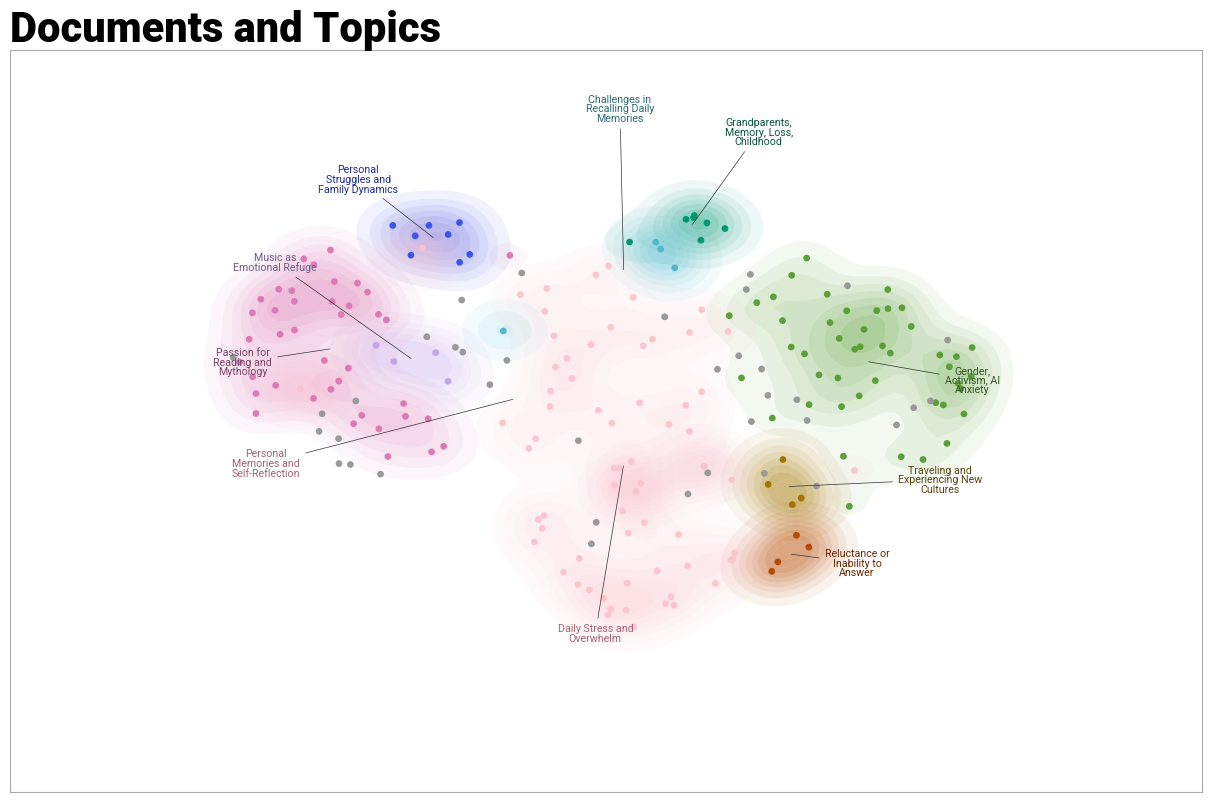

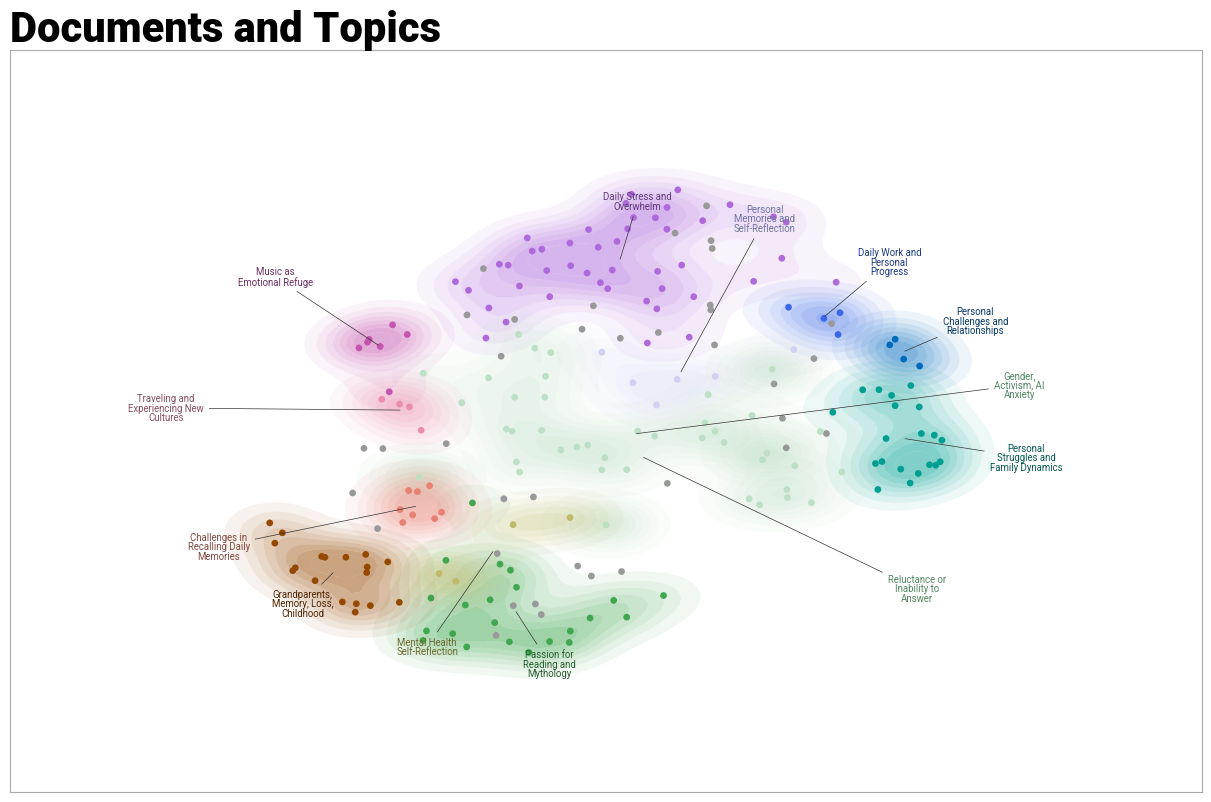

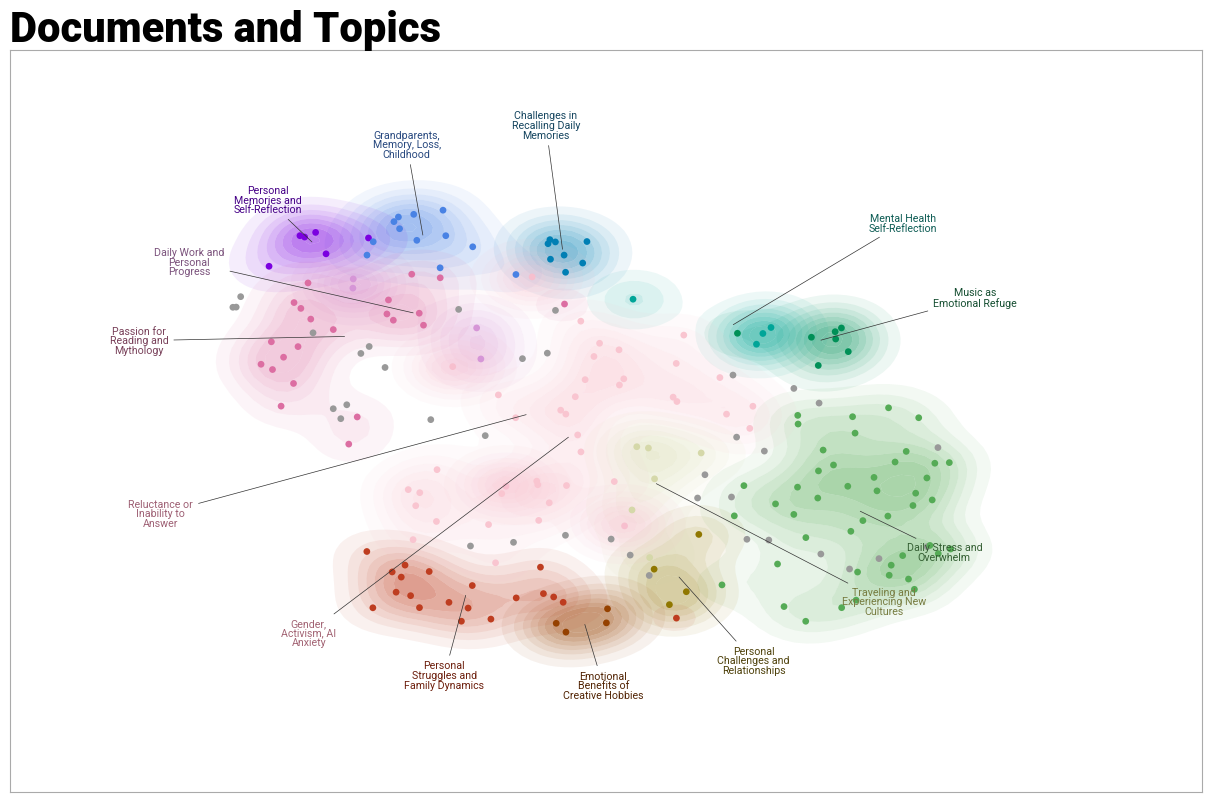

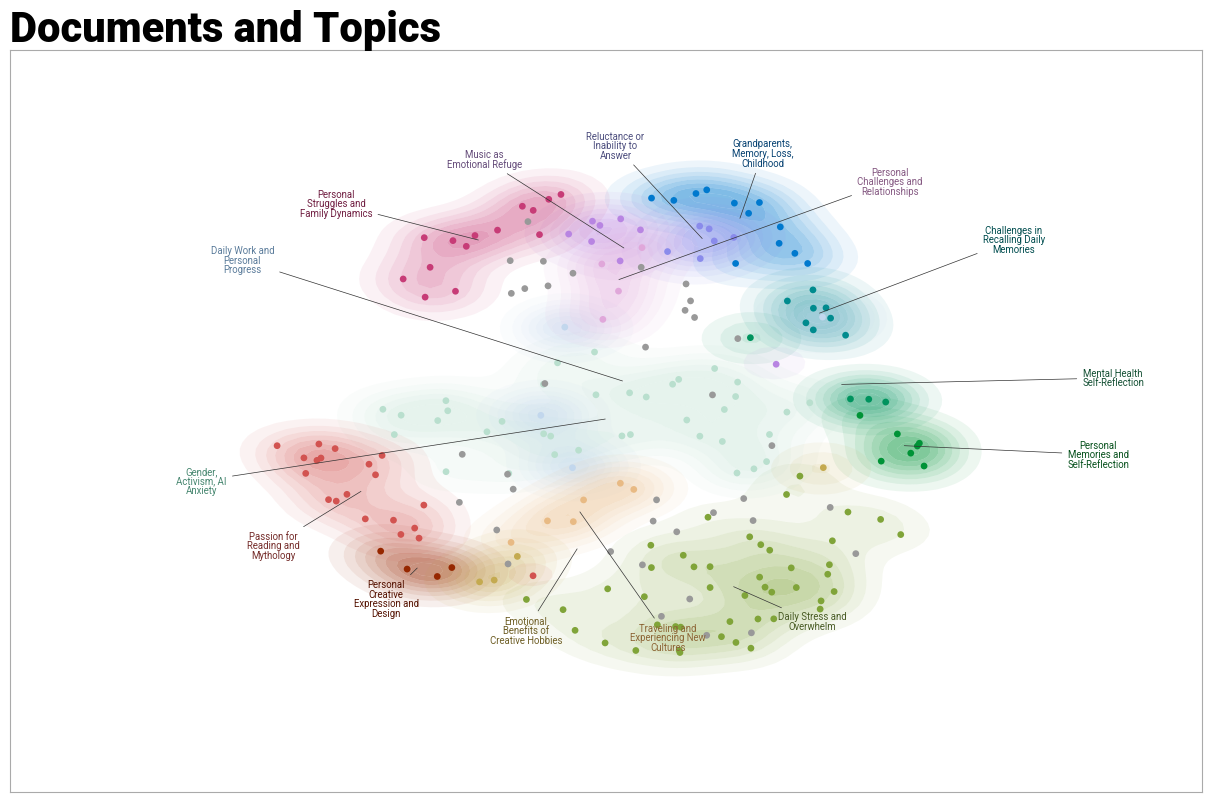

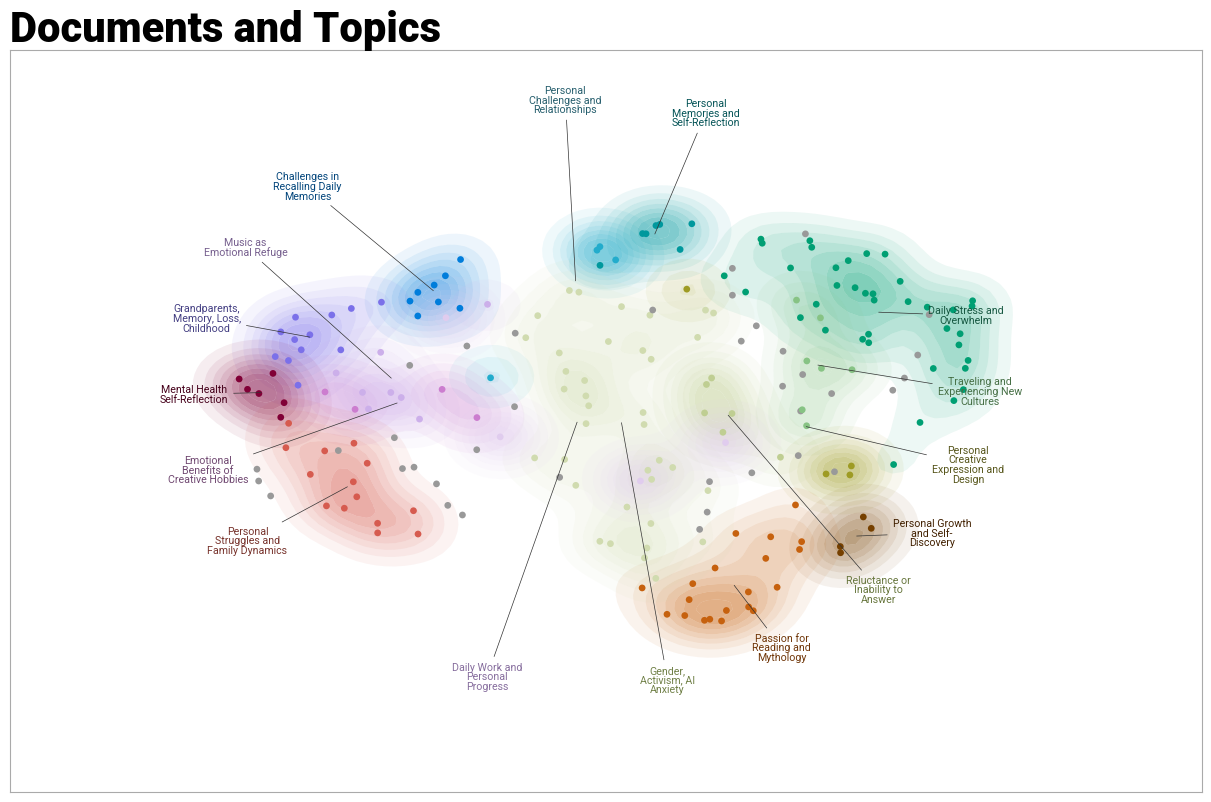

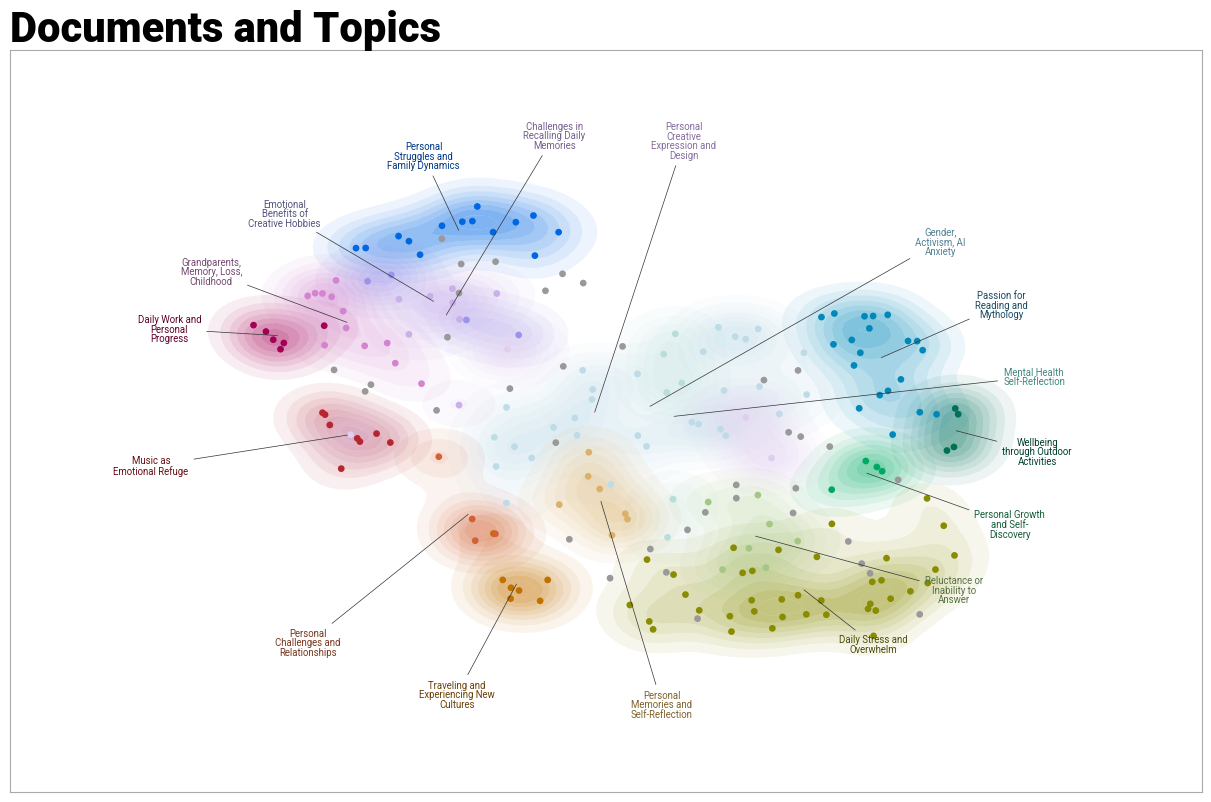

In [ ]:
num_topics = [11, 14, 15, 16, 17, 18]
for num in num_topics:
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    output_folder = f"../../outputs/bertopic_tuning/reduced_{group_name}/{folder}_reduced_{num}/"
    os.makedirs(output_folder, exist_ok=True)
    texts = df_group["response"].tolist()
    topic_model.reduce_topics(texts, nr_topics=num)
    chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
    chatgpt_topic_labels[-1] = "Outlier Topic"
    topic_model.set_topic_labels(chatgpt_topic_labels)

    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)

# noADHD

In [21]:
group_name = "noADHD"
folders = [name for name in os.listdir(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/") if os.path.isdir(os.path.join(f"../../data/adhd-beliefs-pt/bertopic_tuning/{group_name}/", name))]
folder = [name for name in folders if name.startswith("3_")][0]
folder

'3_20250824_222353'

Running preliminary steps for group: noADHD, folder: 3_20250824_222353
noADHD


2025-08-25 00:21:40,657 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:21:40,660 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:21:40,693 - BERTopic - Representation - Completed ✓
2025-08-25 00:21:40,695 - BERTopic - Topic reduction - Reduced number of topics from 37 to 33


🔄 Generating hierarchical topics...


100%|██████████| 31/31 [00:00<00:00, 606.93it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002140_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002140_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_33
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 33
📊 Number of real topics (excluding outliers): 32
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002142_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002142_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     13   
1    Gosto de ver séries porque relatam relações sa...     20   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     17   
4    Historia da arte \nÉ só tão interessante. Para...      4   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     27   
350  As vezes aborrece-me ter de escrever/responder...     16   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 13_gosto_cozinhar_adoro_felizes   
1          20_historia_forma_algum tipo_saudáveis   
2                       0_tarde_acordei_manhã_dia   
3    17_história_anime_animais_interesse especial   
4        4_políticas_física_política_interessante   
..                                            ...   
348                       -1_jogo_algo_sempre_dia   
349              27_dias semana_base_data_escrita   
350          16_questionário_parece_escrever_aqui   
351                       -1_jogo_algo_sempre_dia   
352                       -1_jogo_algo_sempre_dia   

                                      CustomName  \
0            Personal Achievement and Resilience   
1    Volunteer Firefighter Leadership Invitation   
2                Personal Daily Life Experiences   
3             Personal Growth Through Reflection   
4                   Passion for Game Development   
..                                           ...   
348                                Outlier Topic   
349          Discomfort Writing Sensitive Topics   
350        Feminism, Politics, and Social Change   
351                                Outlier Topic   
352                                Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [historia, forma, algum tipo, saudáveis, histó...   
2    [tarde, acordei, manhã, dia, trabalhar, casa, ...   
3    [história, anime, animais, interesse especial,...   
4    [políticas, física, política, interessante, te...   
..                                                 ...   
348  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, parece, escrever, aqui, chegou,...   
351  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   
352  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   

                                               KeyBERT  \
0    [entreguei, senti bem, feliz, stressante, sint...   
1                                 [, , , , , , , , , ]   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [momento senti, deixei, levei, olhando trás, m...   
4    [gosto jogar, jogos, jogar jogos, game dev, go...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [temas, escrever algo, escrever, pessoal, sint...   
350  [influência, políticas, sociais, social, medo,...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                            OpenAI  \
0            [Personal Achievement and Resilience]   
1    [Volunteer Firefighter Leadership Invitation]   
2                [Personal Daily Life Experiences]   
3             [Personal Growth Through Reflection]   
4                   [Passion for Game Development]   
..                                             ...   
348           [Daily Life and Personal Challenges]   
349          [Discomfort Writing Sensitive Topics]   
350        [Feminism, Politics, and Social Change]   
351           [Daily Life and Personal Challenges]   
352           [

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002144_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002144_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_33
------------------------------------------------------------


4it [00:00, 91.67it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002145_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002145_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_33
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002152_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002152_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_33
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:22:48,394 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:22:48,397 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:22:48,430 - BERTopic - Representation - Completed ✓
2025-08-25 00:22:48,431 - BERTopic - Topic reduction - Reduced number of topics from 37 to 31


🔄 Generating hierarchical topics...


100%|██████████| 29/29 [00:00<00:00, 611.90it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002248_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002248_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_31
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 31
📊 Number of real topics (excluding outliers): 30
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002250_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002250_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     13   
1    Gosto de ver séries porque relatam relações sa...     21   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     18   
4    Historia da arte \nÉ só tão interessante. Para...      4   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     26   
350  As vezes aborrece-me ter de escrever/responder...     16   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 13_gosto_cozinhar_adoro_felizes   
1          21_historia_forma_algum tipo_saudáveis   
2                       0_tarde_acordei_dia_tempo   
3    18_história_anime_animais_interesse especial   
4        4_políticas_física_interessante_política   
..                                            ...   
348                       -1_jogo_algo_sempre_dia   
349              26_dias semana_base_data_escrita   
350          16_questionário_parece_escrever_aqui   
351                       -1_jogo_algo_sempre_dia   
352                       -1_jogo_algo_sempre_dia   

                                    CustomName  \
0          Personal Achievement and Resilience   
1    Immersion in Fiction and Animal Sanctuary   
2              Personal Daily Life Experiences   
3      Creative Artistic Expression and Design   
4                 Passion for Game Development   
..                                         ...   
348                              Outlier Topic   
349       Personal Struggles and Relationships   
350      Feminism, Politics, and Social Change   
351                              Outlier Topic   
352                              Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [historia, forma, algum tipo, saudáveis, histó...   
2    [tarde, acordei, dia, tempo, trabalho, manhã, ...   
3    [história, anime, animais, interesse especial,...   
4    [políticas, física, interessante, política, te...   
..                                                 ...   
348  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, parece, escrever, aqui, chegou,...   
351  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   
352  [jogo, algo, sempre, dia, hoje, passar, tudo, ...   

                                               KeyBERT  \
0    [entreguei, senti bem, feliz, stressante, sint...   
1    [anime, fantasia, gostar tanto, magia, princip...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [criatividade, criativa, fazer, utilizar, arte...   
4    [gosto jogar, jogos, jogar jogos, game dev, go...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [incomodar, dor, dores, acordei tarde, triste,...   
350  [influência, políticas, sociais, social, medo,...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                          OpenAI  \
0          [Personal Achievement and Resilience]   
1    [Immersion in Fiction and Animal Sanctuary]   
2              [Personal Daily Life Experiences]   
3      [Creative Artistic Expression and Design]   
4                 [Passion for Game Development]   
..                                           ...   
348         [Daily Life and Personal Challenges]   
349       [Personal Struggles and Relationships]   
350      [Feminism, Politics, and Social Change]   
351         [Daily Life and Personal Challenges]   
352         [Daily Life and Personal Challenges]   

        

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002252_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002252_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_31
------------------------------------------------------------


4it [00:00, 92.55it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002253_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002253_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_31
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002259_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002259_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_31
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:23:52,181 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:23:52,186 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:23:52,218 - BERTopic - Representation - Completed ✓
2025-08-25 00:23:52,220 - BERTopic - Topic reduction - Reduced number of topics from 37 to 28


🔄 Generating hierarchical topics...


100%|██████████| 26/26 [00:00<00:00, 546.20it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002352_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002352_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_28
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 28
📊 Number of real topics (excluding outliers): 27
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002353_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002353_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     12   
1    Gosto de ver séries porque relatam relações sa...     18   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     14   
4    Historia da arte \nÉ só tão interessante. Para...      7   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     24   
350  As vezes aborrece-me ter de escrever/responder...     15   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 12_gosto_cozinhar_adoro_felizes   
1          18_historia_forma_algum tipo_saudáveis   
2                      0_dia_tarde_trabalho_tempo   
3    14_história_anime_animais_interesse especial   
4        7_políticas_física_interessante_política   
..                                            ...   
348                       -1_dia_algo_jogo_sempre   
349              24_dias semana_base_data_escrita   
350          15_questionário_parece_escrever_aqui   
351                       -1_dia_algo_jogo_sempre   
352                       -1_dia_algo_jogo_sempre   

                                       CustomName  \
0                         Loss, Grief, and Coping   
1         Creative Artistic Expression and Design   
2                 Personal Daily Life Experiences   
3             Childhood Memories and Family Bonds   
4                     Reading and Personal Growth   
..                                            ...   
348                                 Outlier Topic   
349       Emotional Impact of Visual Storytelling   
350  Personal Pleasures and Sentimental Favorites   
351                                 Outlier Topic   
352                                 Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [historia, forma, algum tipo, saudáveis, histó...   
2    [dia, tarde, trabalho, tempo, acordei, casa, m...   
3    [história, anime, animais, interesse especial,...   
4    [políticas, física, interessante, política, te...   
..                                                 ...   
348  [dia, algo, jogo, sempre, hoje, passar, tudo, ...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, parece, escrever, aqui, chegou,...   
351  [dia, algo, jogo, sempre, hoje, passar, tudo, ...   
352  [dia, algo, jogo, sempre, hoje, passar, tudo, ...   

                                               KeyBERT  \
0    [cresci, saudade, falecimento, dor, memória, e...   
1    [criatividade, criativa, fazer, utilizar, arte...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [memória vem, memória, memórias, saudade, saud...   
4    [livros, leitura, livro, ler, género gosto, go...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [ver séries, séries, filme, cinema, histórias,...   
350  [cozinhar, porque gosto, doces, gosto ver, com...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                             OpenAI  \
0                         [Loss, Grief, and Coping]   
1         [Creative Artistic Expression and Design]   
2                 [Personal Daily Life Experiences]   
3             [Childhood Memories and Family Bonds]   
4                     [Reading and Personal Growth]   
..                                              ...   
348            [Daily Life and Personal Challenges]   
349       [Emotional Impact of Visual Storytelling]   
350  [Personal Pleasures and Sentimental Favorites]   
351            [Daily Life and Personal Challen

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002355_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002355_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_28
------------------------------------------------------------


4it [00:00, 91.98it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002357_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002357_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_28
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002402_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002402_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_28
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:24:51,680 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:24:51,684 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:24:51,715 - BERTopic - Representation - Completed ✓
2025-08-25 00:24:51,716 - BERTopic - Topic reduction - Reduced number of topics from 37 to 27


🔄 Generating hierarchical topics...


100%|██████████| 25/25 [00:00<00:00, 607.16it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002451_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002451_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_27
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 27
📊 Number of real topics (excluding outliers): 26
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002453_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002453_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     10   
1    Gosto de ver séries porque relatam relações sa...     17   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     13   
4    Historia da arte \nÉ só tão interessante. Para...      6   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     23   
350  As vezes aborrece-me ter de escrever/responder...     14   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 10_gosto_cozinhar_adoro_felizes   
1          17_historia_forma_algum tipo_saudáveis   
2                      0_dia_tarde_trabalho_tempo   
3    13_história_anime_animais_interesse especial   
4        6_políticas_física_interessante_política   
..                                            ...   
348                       -1_dia_algo_sempre_jogo   
349              23_dias semana_base_data_escrita   
350          14_questionário_parece_escrever_aqui   
351                       -1_dia_algo_sempre_jogo   
352                       -1_dia_algo_sempre_jogo   

                                         CustomName  \
0    Adolescent Friendship Conflicts and Resilience   
1                Personal Growth Through Reflection   
2                   Personal Daily Life Experiences   
3               Personal Achievement and Resilience   
4                   Connection with Nature and Self   
..                                              ...   
348                                   Outlier Topic   
349              Procrastination and Mental Fatigue   
350             Childhood Memories and Family Bonds   
351                                   Outlier Topic   
352                                   Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [historia, forma, algum tipo, saudáveis, histó...   
2    [dia, tarde, trabalho, tempo, casa, acordei, f...   
3    [história, anime, animais, interesse especial,...   
4    [políticas, física, interessante, política, te...   
..                                                 ...   
348  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, parece, escrever, aqui, chegou,...   
351  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   
352  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   

                                               KeyBERT  \
0    [conheci, amigo, amizades, medo, achava, outro...   
1    [momento senti, deixei, levei, olhando trás, m...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [entreguei, senti bem, feliz, stressante, sint...   
4    [permite relaxar, relaxar, apanhar sol, gosto ...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [escrever, muitas vezes, dificuldades, fazer, ...   
350  [memória vem, memória, memórias, saudade, saud...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                               OpenAI  \
0    [Adolescent Friendship Conflicts and Resilience]   
1                [Personal Growth Through Reflection]   
2                   [Personal Daily Life Experiences]   
3               [Personal Achievement and Resilience]   
4                   [Connection with Nature and Self]   
..                                                ...   
348              [Daily Life and Personal Challenges]   
349              [Procrastination and Mental Fatigue]   
350             [Childhood Memories and Family Bonds]   
351

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002455_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002455_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_27
------------------------------------------------------------


4it [00:00, 83.56it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002456_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002456_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_27
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002501_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002501_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_27
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:25:46,893 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:25:46,897 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:25:46,927 - BERTopic - Representation - Completed ✓
2025-08-25 00:25:46,929 - BERTopic - Topic reduction - Reduced number of topics from 37 to 26


🔄 Generating hierarchical topics...


100%|██████████| 24/24 [00:00<00:00, 603.29it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002547_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002547_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_26
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 26
📊 Number of real topics (excluding outliers): 25
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002548_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002548_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     10   
1    Gosto de ver séries porque relatam relações sa...     16   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     12   
4    Historia da arte \nÉ só tão interessante. Para...      4   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     22   
350  As vezes aborrece-me ter de escrever/responder...     13   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 10_gosto_cozinhar_adoro_felizes   
1          16_historia_forma_algum tipo_saudáveis   
2                      0_dia_tarde_trabalho_tempo   
3    12_história_anime_animais_interesse especial   
4           4_gosto_física_políticas_interessante   
..                                            ...   
348                       -1_dia_algo_sempre_jogo   
349              22_dias semana_base_data_escrita   
350          13_questionário_parece_escrever_aqui   
351                       -1_dia_algo_sempre_jogo   
352                       -1_dia_algo_sempre_jogo   

                                         CustomName  \
0    Adolescent Friendship Conflicts and Resilience   
1             Feminism, Politics, and Social Change   
2                   Personal Daily Life Experiences   
3                           Loss, Grief, and Coping   
4                      Passion for Game Development   
..                                              ...   
348                                   Outlier Topic   
349                 Mental Health Diagnosis Journey   
350             Personal Achievement and Resilience   
351                                   Outlier Topic   
352                                   Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [historia, forma, algum tipo, saudáveis, histó...   
2    [dia, tarde, trabalho, tempo, fazer, casa, aco...   
3    [história, anime, animais, interesse especial,...   
4    [gosto, física, políticas, interessante, polít...   
..                                                 ...   
348  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, parece, escrever, aqui, chegou,...   
351  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   
352  [dia, algo, sempre, jogo, hoje, tudo, passar, ...   

                                               KeyBERT  \
0    [conheci, amigo, amizades, medo, achava, outro...   
1    [influência, políticas, sociais, social, medo,...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [cresci, saudade, falecimento, dor, memória, e...   
4    [gosto jogar, jogos, jogar jogos, game dev, go...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [saúde mental, fiquei pensar, mental, medo, ps...   
350  [entreguei, senti bem, feliz, stressante, sint...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                               OpenAI  \
0    [Adolescent Friendship Conflicts and Resilience]   
1             [Feminism, Politics, and Social Change]   
2                   [Personal Daily Life Experiences]   
3                           [Loss, Grief, and Coping]   
4                      [Passion for Game Development]   
..                                                ...   
348              [Daily Life and Personal Challenges]   
349                 [Mental Health Diagnosis Journey]   
350             [Personal Achievement and Resilience]   
351

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002550_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002550_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_26
------------------------------------------------------------


4it [00:00, 94.96it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002552_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002552_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_26
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002556_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002556_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_26
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:26:41,141 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:26:41,146 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:26:41,175 - BERTopic - Representation - Completed ✓
2025-08-25 00:26:41,176 - BERTopic - Topic reduction - Reduced number of topics from 37 to 24


🔄 Generating hierarchical topics...


100%|██████████| 22/22 [00:00<00:00, 589.00it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002641_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002641_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_24
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 24
📊 Number of real topics (excluding outliers): 23
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002642_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002642_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     10   
1    Gosto de ver séries porque relatam relações sa...      6   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     12   
4    Historia da arte \nÉ só tão interessante. Para...      4   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     20   
350  As vezes aborrece-me ter de escrever/responder...     13   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 10_gosto_cozinhar_adoro_felizes   
1                        6_ler_livros_forma_gosto   
2                      0_dia_tarde_tempo_trabalho   
3    12_história_anime_animais_interesse especial   
4           4_gosto_física_políticas_interessante   
..                                            ...   
348                       -1_dia_algo_sempre_jogo   
349              20_dias semana_base_data_escrita   
350          13_questionário_escrever_parece_aqui   
351                       -1_dia_algo_sempre_jogo   
352                       -1_dia_algo_sempre_jogo   

                                         CustomName  \
0    Adolescent Friendship Conflicts and Resilience   
1                   Connection with Nature and Self   
2                   Personal Daily Life Experiences   
3                           Loss, Grief, and Coping   
4                      Passion for Game Development   
..                                              ...   
348                                   Outlier Topic   
349     Volunteer Firefighter Leadership Invitation   
350             Personal Achievement and Resilience   
351                                   Outlier Topic   
352                                   Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [ler, livros, forma, gosto, saga, lido, histór...   
2    [dia, tarde, tempo, trabalho, fazer, hoje, cas...   
3    [história, anime, animais, interesse especial,...   
4    [gosto, física, políticas, interessante, polít...   
..                                                 ...   
348  [dia, algo, sempre, jogo, hoje, fazer, tudo, p...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [questionário, escrever, parece, aqui, chegou,...   
351  [dia, algo, sempre, jogo, hoje, fazer, tudo, p...   
352  [dia, algo, sempre, jogo, hoje, fazer, tudo, p...   

                                               KeyBERT  \
0    [conheci, amigo, amizades, medo, achava, outro...   
1    [permite relaxar, relaxar, apanhar sol, gosto ...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [cresci, saudade, falecimento, dor, memória, e...   
4    [gosto jogar, jogos, jogar jogos, game dev, go...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349                               [, , , , , , , , , ]   
350  [entreguei, senti bem, feliz, stressante, sint...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                               OpenAI  \
0    [Adolescent Friendship Conflicts and Resilience]   
1                   [Connection with Nature and Self]   
2                   [Personal Daily Life Experiences]   
3                           [Loss, Grief, and Coping]   
4                      [Passion for Game Development]   
..                                                ...   
348              [Daily Life and Personal Challenges]   
349     [Volunteer Firefighter Leadership Invitation]   
350             [Personal Achievement and Resilience]   
351

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002644_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002644_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_24
------------------------------------------------------------


4it [00:00, 99.36it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002646_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002646_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_24
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002650_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002650_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_24
------------------------------------------------------------
✅ Document datamap created succes

2025-08-25 00:27:31,641 - BERTopic - Topic reduction - Reducing number of topics
2025-08-25 00:27:31,645 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 00:27:31,674 - BERTopic - Representation - Completed ✓
2025-08-25 00:27:31,675 - BERTopic - Topic reduction - Reduced number of topics from 37 to 22


🔄 Generating hierarchical topics...


100%|██████████| 20/20 [00:00<00:00, 600.90it/s]


✅ Hierarchical topics generated successfully
🔄 Creating hierarchy visualization...
🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_noADHD as PNG: 20250825_002731_bertopic_hierarchy_noadhd.png
📊 Saved bertopic_hierarchy_noADHD as HTML: 20250825_002731_bertopic_hierarchy_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_22
------------------------------------------------------------
✅ Hierarchy visualization saved
📊 Number of unique topics: 22
📊 Number of real topics (excluding outliers): 21
🔄 Creating standard topic visualization...
🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_noADHD as PNG: 20250825_002733_bertopic_topics_noadhd.png
📊 Saved bertopic_topics_noADHD as HTML: 20250825_002733_bertopic_topics_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_noADHD'
📁 Location: /home

Document  Topic  \
0    Adoro cozinhar, porque sinto que é a forma ide...     10   
1    Gosto de ver séries porque relatam relações sa...      5   
2    Campos de ferias. Temos que criar o campo todo...      0   
3    Taylor Swift, amo o seu liricismo e a maneira ...     11   
4    Historia da arte \nÉ só tão interessante. Para...      1   
..                                                 ...    ...   
348  A noção de que procuro ser sempre uma boa pess...     -1   
349                                                  —     18   
350  As vezes aborrece-me ter de escrever/responder...      0   
351  Maiores dificuldades que sempre senti.. Concen...     -1   
352  Alguém me mande um milagre, I am going crazy, ...     -1   

                                             Name  \
0                 10_gosto_cozinhar_adoro_felizes   
1                        5_ler_livros_forma_gosto   
2                         0_dia_fazer_tempo_tarde   
3    11_história_anime_animais_interesse especial   
4             1_gosto_desporto_jogos_interessante   
..                                            ...   
348                       -1_dia_algo_sempre_hoje   
349              18_dias semana_base_data_escrita   
350                       0_dia_fazer_tempo_tarde   
351                       -1_dia_algo_sempre_hoje   
352                       -1_dia_algo_sempre_hoje   

                                         CustomName  \
0    Adolescent Friendship Conflicts and Resilience   
1          Politics, Economics, and Quantum Physics   
2                   Personal Daily Life Experiences   
3          Formative Childhood Memories and Regrets   
4          Daily Stress and Productivity Challenges   
..                                              ...   
348                                   Outlier Topic   
349         Creative Artistic Expression and Design   
350                 Personal Daily Life Experiences   
351                                   Outlier Topic   
352                                   Outlier Topic   

                                        Representation  \
0    [gosto, cozinhar, adoro, felizes, favoritas, v...   
1    [ler, livros, forma, gosto, saga, sinto, histó...   
2    [dia, fazer, tempo, tarde, trabalho, hoje, cas...   
3    [história, anime, animais, interesse especial,...   
4    [gosto, desporto, jogos, interessante, jogar, ...   
..                                                 ...   
348  [dia, algo, sempre, hoje, jogo, fazer, tudo, p...   
349  [dias semana, base, data, escrita, semana, dia...   
350  [dia, fazer, tempo, tarde, trabalho, hoje, cas...   
351  [dia, algo, sempre, hoje, jogo, fazer, tudo, p...   
352  [dia, algo, sempre, hoje, jogo, fazer, tudo, p...   

                                               KeyBERT  \
0    [conheci, amigo, amizades, medo, achava, outro...   
1    [políticas, politica, política, entender, prob...   
2    [acordei tarde, hoje acordei, comecei, acordei...   
3    [memória, ansiedade, desconforto, mim, altura,...   
4    [stress, hoje senti, acordei, stressada, fique...   
..                                                 ...   
348  [senti, cansativo, vezes, sinto, últimos, ir, ...   
349  [criatividade, criativa, fazer, utilizar, arte...   
350  [acordei tarde, hoje acordei, comecei, acordei...   
351  [senti, cansativo, vezes, sinto, últimos, ir, ...   
352  [senti, cansativo, vezes, sinto, últimos, ir, ...   

                                               OpenAI  \
0    [Adolescent Friendship Conflicts and Resilience]   
1          [Politics, Economics, and Quantum Physics]   
2                   [Personal Daily Life Experiences]   
3          [Formative Childhood Memories and Regrets]   
4          [Daily Stress and Productivity Challenges]   
..                                                ...   
348              [Daily Life and Personal Challenges]   
349         [Creative Artistic Expression and Design]   
350                 [Personal Daily Life Experiences]   
351

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_noADHD as PNG: 20250825_002735_bertopic_heatmap_noadhd.png
📊 Saved bertopic_heatmap_noADHD as HTML: 20250825_002735_bertopic_heatmap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_22
------------------------------------------------------------


4it [00:00, 91.12it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_noADHD as PNG: 20250825_002737_bertopic_topics_per_class_noadhd.png
📊 Saved bertopic_topics_per_class_noADHD as HTML: 20250825_002737_bertopic_topics_per_class_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_22
------------------------------------------------------------
🔄 Creating document datamap...
🖼️  Saved bertopic_document_datamap_noADHD as PNG: 20250825_002741_bertopic_document_datamap_noadhd.png
📊 Saved bertopic_document_datamap_noADHD as HTML: 20250825_002741_bertopic_document_datamap_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_tuning/noADHD/3_20250824_222353_reduced_22
------------------------------------------------------------
✅ Document datamap created succes

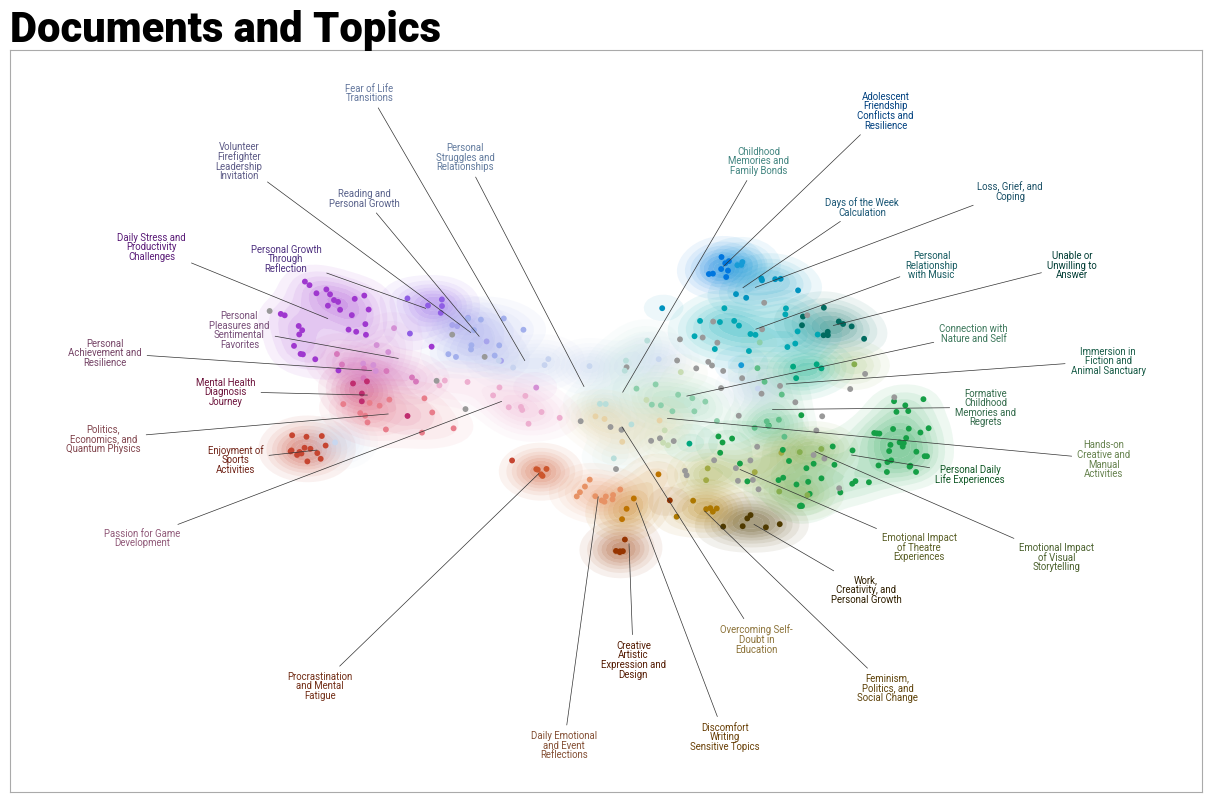

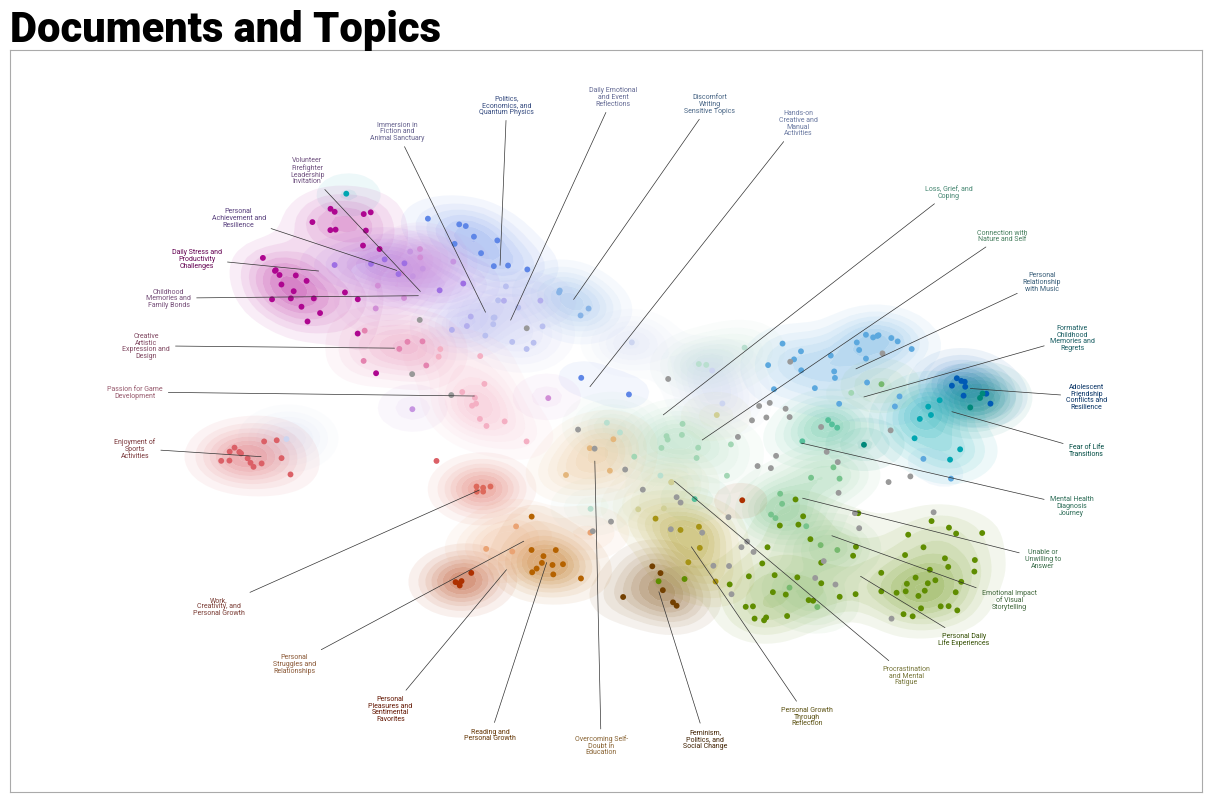

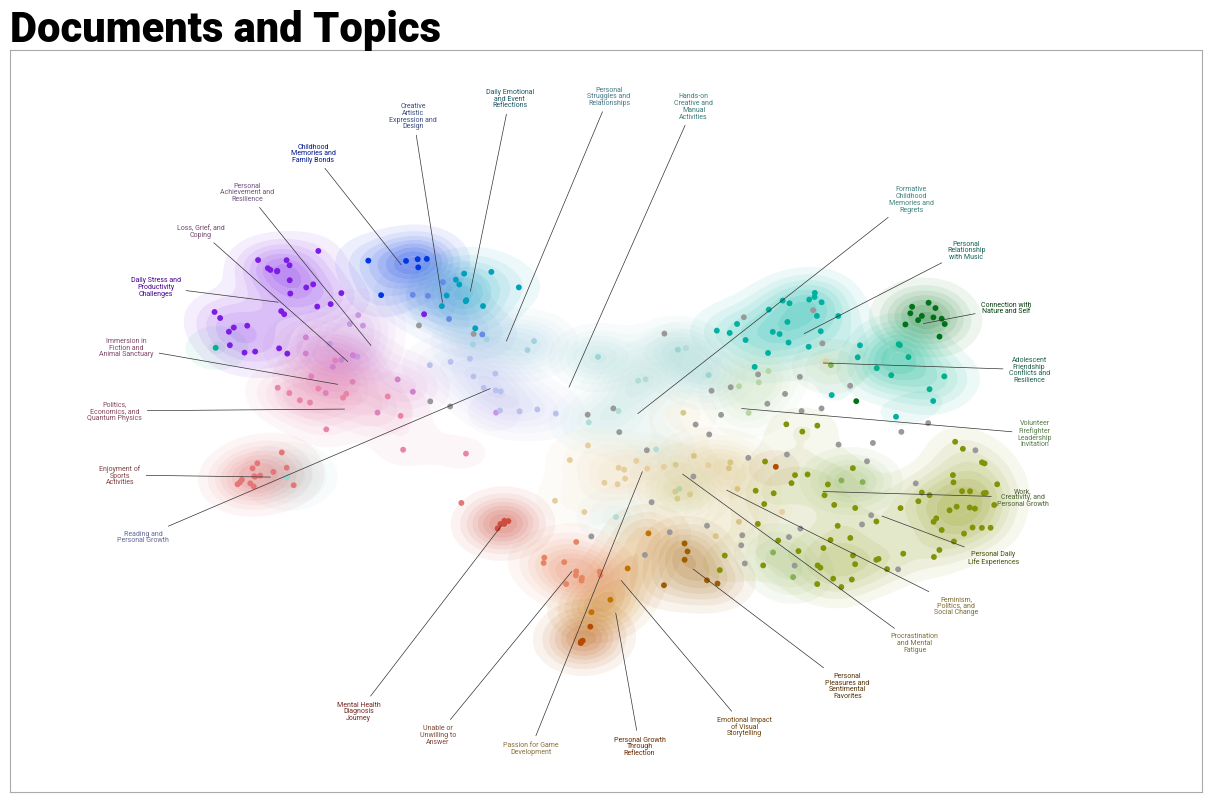

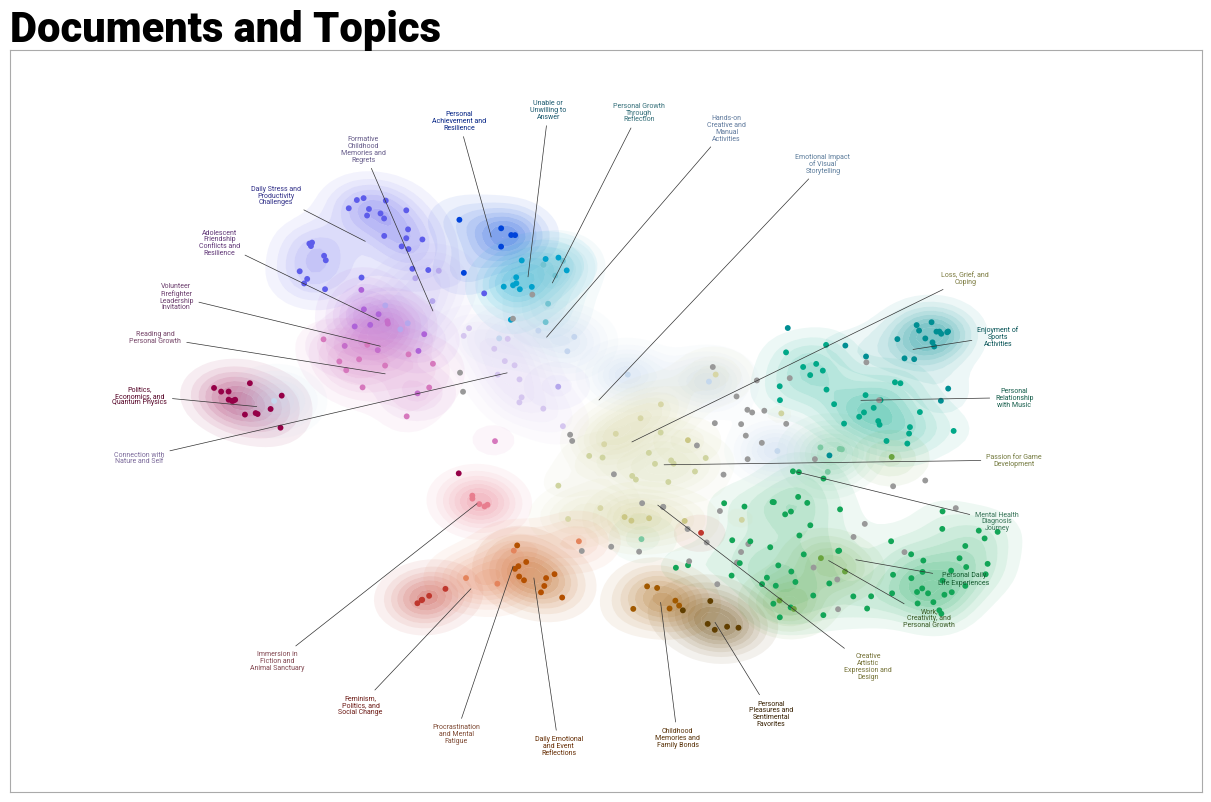

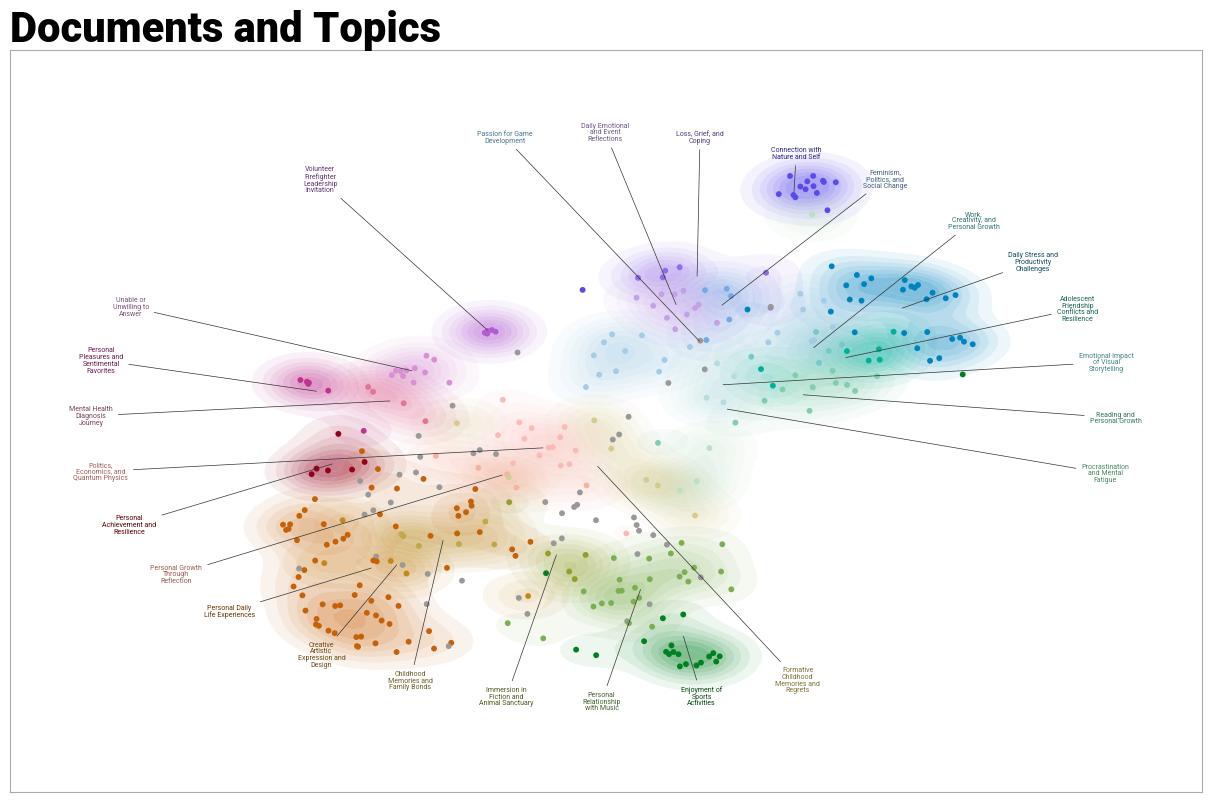

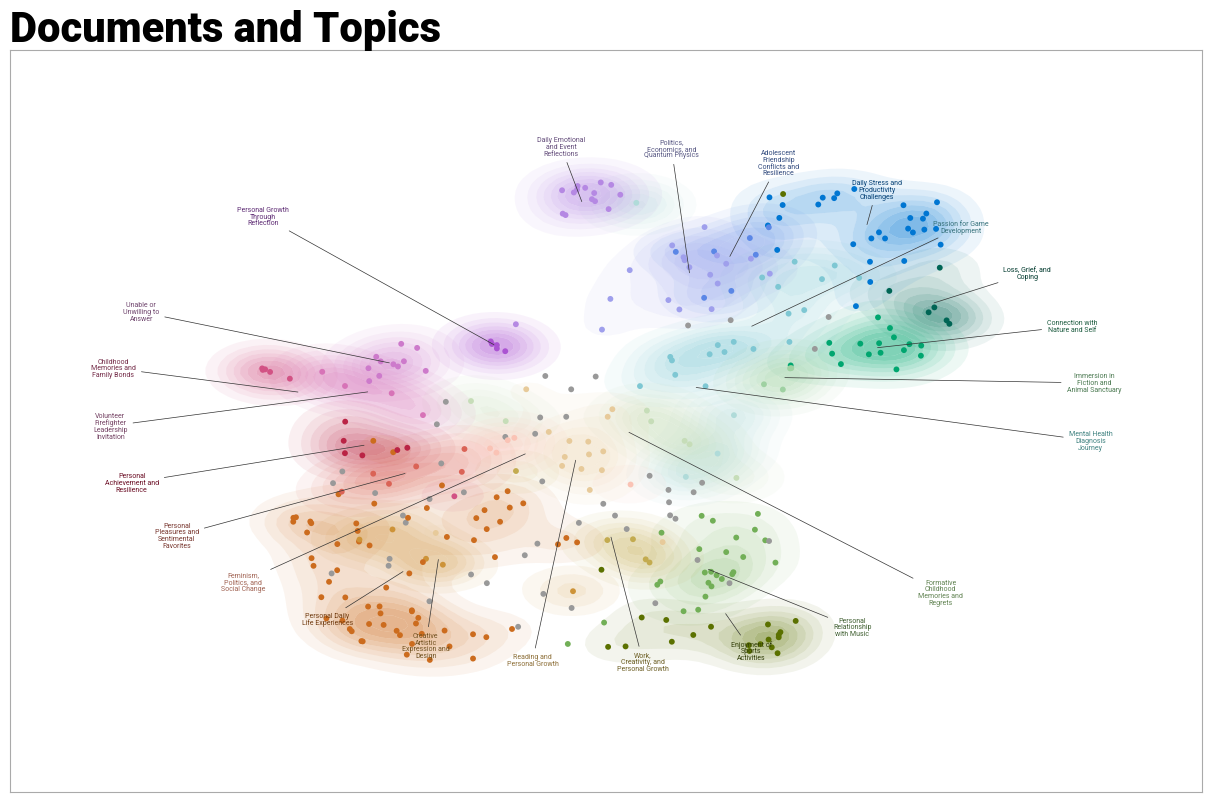

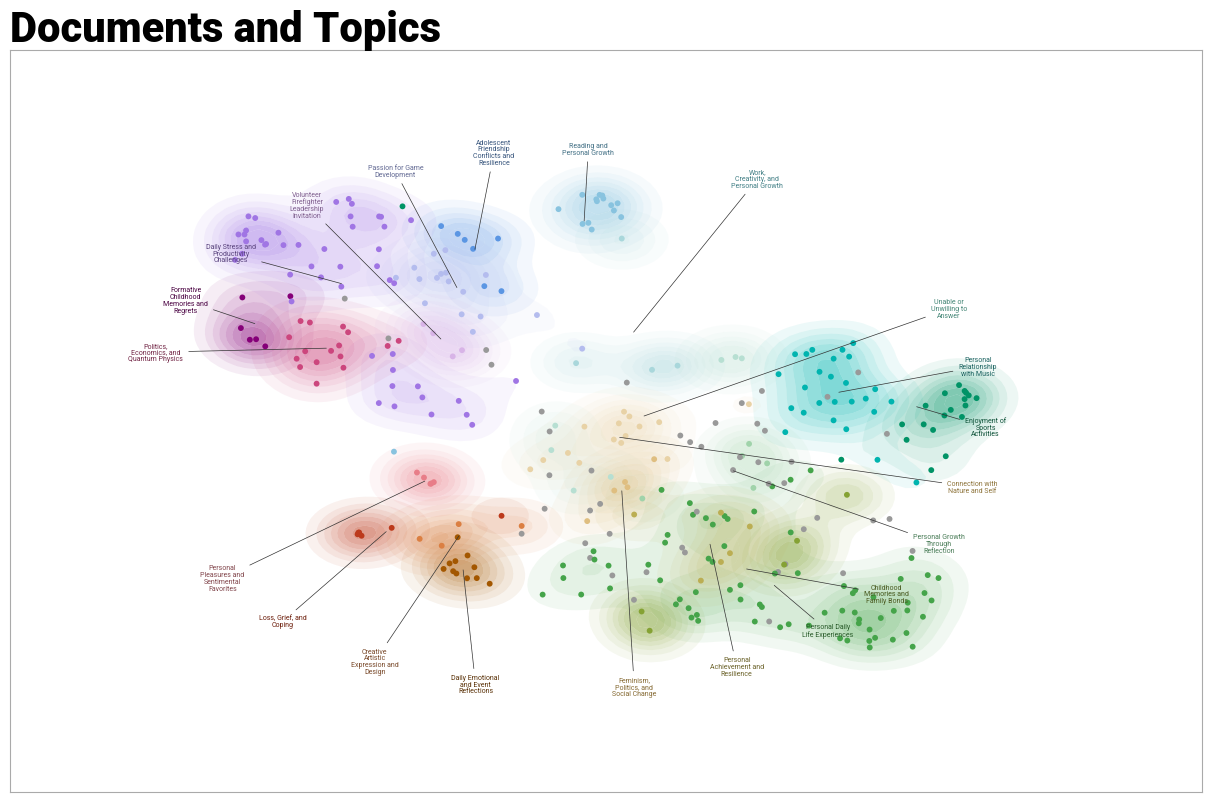

In [ ]:
num_topics = [33, 31, 28, 27, 26, 24, 22]
for num in num_topics:
    df_group, topic_model, output_folder = preliminary_steps(group_name, folder)
    output_folder = f"../../outputs/bertopic_tuning/reduced_{group_name}/{folder}_reduced_{num}/"
    os.makedirs(output_folder, exist_ok=True)
    texts = df_group["response"].tolist()
    topic_model.reduce_topics(texts, nr_topics=num)
    chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
    chatgpt_topic_labels[-1] = "Outlier Topic"
    topic_model.set_topic_labels(chatgpt_topic_labels)

    check_hierarchy(topic_model, df_group, output_folder, group_name)
    run_bertopic_evals(topic_model, df_group, output_folder)
    run_bertopic_viz(topic_model, df_group, output_folder, group_name)